In [6]:
import numpy as np
import sobol_seq
import vorostereology as vs
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from scipy.spatial import Voronoi, voronoi_plot_2d
import voroplusplus as vpp
import pyvoro
from scipy import ndimage
import pandas as pd
import csv
from PIL import Image, ImageChops
import os
import os.path as osp



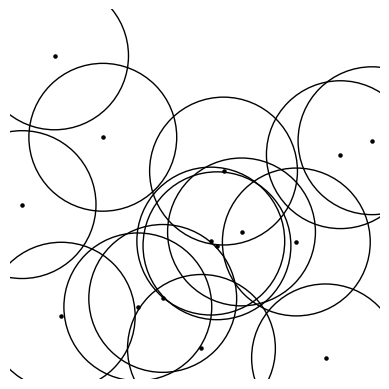

In [118]:
from calendar import c
from cycler import V


def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def vorarr(points, regions, vertices, width, height, dpi=100):
    fig = plt.Figure(figsize=(width/dpi, height/dpi), dpi=dpi)
    canvas = FigureCanvas(fig)
    ax = fig.add_axes([0,0,1,1])

    # colorize
    for region in regions:
        polygon = vertices[region]
        ax.fill(*zip(*polygon), alpha=0.4)

    ax.plot(points[:,0], points[:,1], 'ko')
    ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

    canvas.draw()
    return np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

length_of_cube_sides = 1
n=15

s = np.random.default_rng(120).uniform(0, length_of_cube_sides, size=(n,2))

vor = Voronoi(s)
regions, vertices = voronoi_finite_polygons_2d(vor)

# arr = vorarr(s, regions, vertices, width=1000, height=1000)

fig2, ax2 = plt.subplots(1, 1)
colors = ["r", "b", "g", "y",  "brown", "purple", "cyan", "grey", "pink"]

coll = PolyCollection([vertices[region] for region in regions], facecolors=colors*(len(regions)//len(colors)), edgecolors='black', closed=True, alpha=0.6)

# ax2.add_collection(coll)
plt.scatter(s[:, 0], s[:, 1], color='black', s=5)

r= 0.2
# Add circles at the points

circs = []
for point_n in range(n):
    x,y = s[point_n]
    circ = plt.Circle(np.array([x,y]), r, color='black', fill=False)
    circs.append(circ)
    plt.gca().add_artist(circ)

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_aspect('equal', adjustable='box')
plt.axis('off')
plt.savefig(f"../figures/PV_diagram_example_{r}.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=True)
plt.show()

# voronoi_plot_2d(Voronoi(s), show_vertices=False)

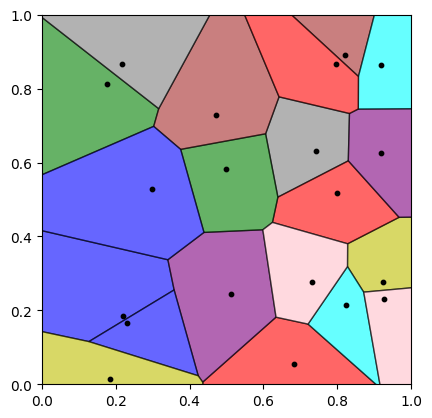

In [ ]:

seed = 118


# ax2.axis("equal")

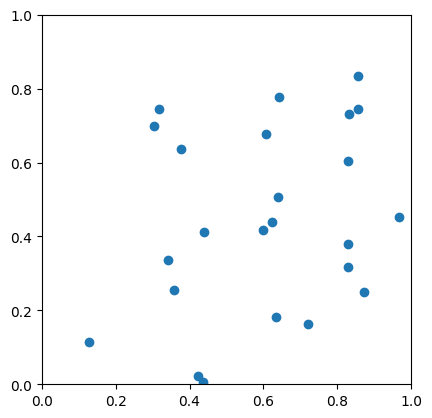

In [38]:
plt.scatter(vertices[:, 0], vertices[:, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [2]:
%matplotlib widget

/tmp/ipykernel_10942/2448630800.py:86: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  im = Image.frombytes("RGB", fig2.canvas.get_width_height(), fig2.canvas.tostring_rgb())


[<PIL.Image.Image image mode=RGB size=406x406>,
 <PIL.Image.Image image mode=RGB size=406x406>,
 <PIL.Image.Image image mode=RGB size=406x406>,
 <PIL.Image.Image image mode=RGB size=406x406>,
 <PIL.Image.Image image mode=RGB size=406x406>]

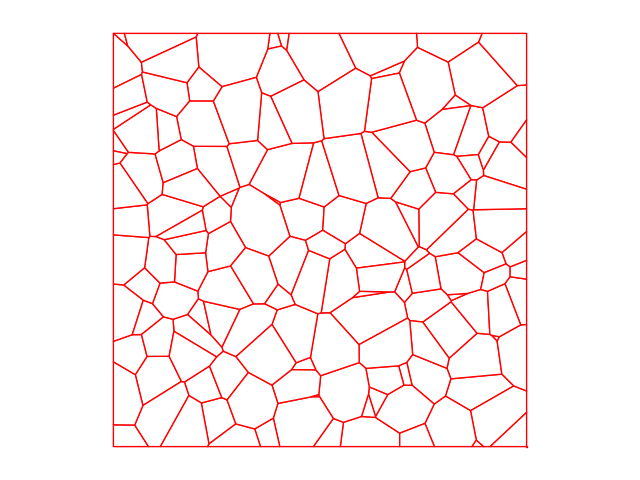

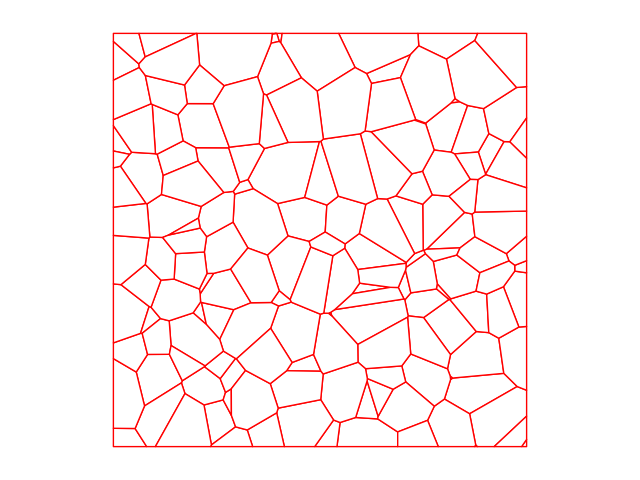

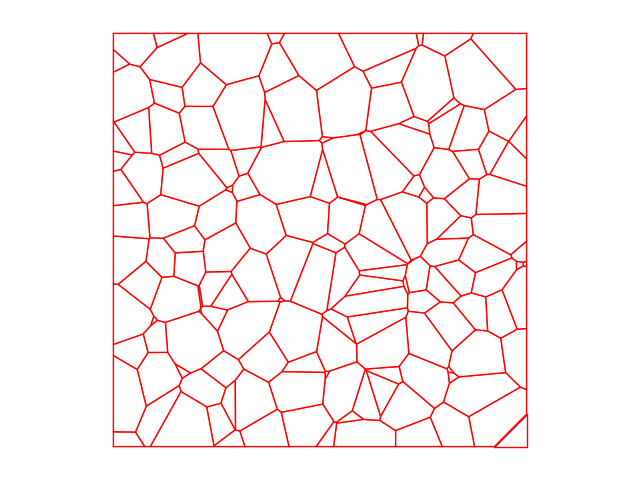

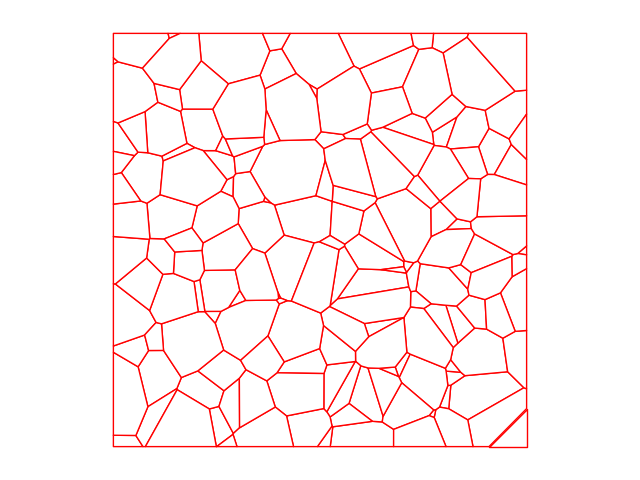

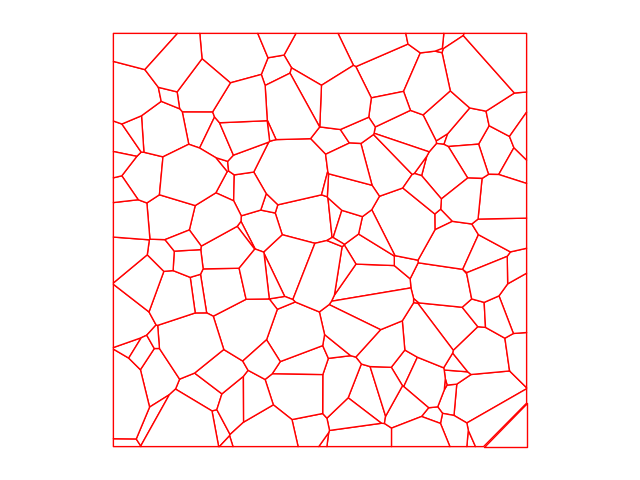

In [3]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

def generate_cross_section(n, length_of_cube_sides = 10, seed=None, weights = None,
                           coefs_cross_section = np.array([1, 0.0, 0.0]),
                           cross_section_locations = np.arange(2.5, 7, 0.5),
                           plot_3d_visualization = False,
                           save_images = True,
                           save_location = "../figures/test",
                           image_name = "test",):
    
    # Setting the variables
    if weights is None:
        weights = np.zeros(n)

    domain=[[0.0, length_of_cube_sides], [0.0, length_of_cube_sides], [0.0, length_of_cube_sides]]
    if seed is None:
        s = np.random.uniform(0,length_of_cube_sides,size=(n,3))
    else:
        s = np.random.default_rng(seed).uniform(0,length_of_cube_sides,size=(n,3))


    # Computing 3d PV
    pycells=pyvoro.compute_voronoi(
        s, # point positions
        domain, # limits
        length_of_cube_sides, # block size
        # particle radii -- optional, and keyword-compatible arg.
        )
    
    # Setting cross sections
    cross_section_tot = []
    for x in range(len(cross_section_locations)):
        cross_section_tot += [vs.compute_cross_section(coeffs=coefs_cross_section, offset = np.array([cross_section_locations[x], 5.0, 10.0]), points = s, domain=domain, weights = weights)]
    
    # Plotting 3d PV with cross sections highlighted
    if plot_3d_visualization:
        fig = plt.figure()
        # ax = Axes3D(fig)
        ax = fig.add_subplot(111, projection='3d')

        for cell_idx, cell in enumerate(pycells):
            for facet_idx, facet in enumerate(cell['faces']):
                idx = np.array(facet['vertices'])
                polygon = m3.art3d.Poly3DCollection([np.array(cell['vertices'])[idx]])
                polygon.set_edgecolor('k')
                polygon.set_alpha(0.1)
                ax.add_collection3d(polygon)

        for x in range(9):
            for cell in cross_section_tot[x]['3d']:
                polygon = m3.art3d.Poly3DCollection([cell])
                polygon.set_color("red")
                polygon.set_edgecolor('k')
                ax.add_collection3d(polygon)

            
        ax.set_xlim3d(domain[0])
        ax.set_ylim3d(domain[1])
        ax.set_zlim3d(domain[2])
        ax.set_box_aspect((1, 1, 1))
        ax.set_axis_off()
        plt.show(block=False)

    if save_images:
        os.makedirs(save_location, exist_ok=True)
    
    image_list = []

    # 
    for section_i in range(len(cross_section_tot)):
        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111)

        coll = PolyCollection(cross_section_tot[section_i]['2d'], facecolors="white", edgecolors='r', closed=True)
        ax2.add_collection(coll)
        ax2.axis("equal")
        ax2.set_axis_off()
        fig2.tight_layout()
        plt.savefig("temp.png")
        im = Image.frombytes("RGB", fig2.canvas.get_width_height(), fig2.canvas.tostring_rgb())
        im = trim(im)
        crop_by = 5
        im = im.crop((crop_by, crop_by, im.width-crop_by, im.height-crop_by))

        if seed is None:
            im_name = f"{image_name}_n={n}_seed=random_size={length_of_cube_sides}_loc={cross_section_locations[section_i]:.2f}.png"
        else:
            im_name = f"{image_name}_n={n}_seed={seed}_size={length_of_cube_sides}_loc={cross_section_locations[section_i]:.2f}.png"
        
        image_list.append(im)
        if save_images:
            im.save(osp.join(save_location, im_name))

    os.remove("temp.png")
    return image_list


generate_cross_section(1000, seed=123, cross_section_locations=np.arange(2.5, 3, 0.1))



In [4]:
# ######################################## Define/ initialize points##############################################
n = 1000
s = np.random.default_rng().uniform(0,10,size=(n,3))

domain = [[0.0, 10.0], [0.0, 10.0], [0.0, 10.0]]
weights = np.zeros(1000)

In [5]:
s10=s/10
domain10 = [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]

In [6]:
#######Generate 3D Voronoi###########
pycells=pyvoro.compute_voronoi(
s, # point positions
domain, # limits
10.0, # block size
# particle radii -- optional, and keyword-compatible arg.
)

In [7]:
pycells10=pyvoro.compute_voronoi(
s10, # point positions
domain10, # limits
1.0, # block size
# particle radii -- optional, and keyword-compatible arg.
)

In [8]:
######Taking 9 cross-sections#####

coeffs =  np.array([1, 0.0, 0.0])
r1=np.arange(2.5, 5, 0.25).tolist()
cross_section_tot = []
for x in range(len(r1)):
 cross_section_tot += [vs.compute_cross_section(coeffs=coeffs, offset = np.array([r1[x], 5.0, 10.0]), points = s, domain=domain, weights = weights)]
 

In [12]:
coeffs10 = np.array([0.5, 0.0, 0.0])
r1=np.arange(0.25, 0.7, 0.05).tolist()
cross_section_tot10 = []
for x in range(len(r1)):
 cross_section_tot10 += [vs.compute_cross_section(coeffs = coeffs10, offset =np.array([r1[x], 0, 0]), points = s10, domain=domain10, weights=weights)]
 

In [10]:
#####Taking the centroid of the visible grains in the cross-sections and create data-set#####
for j in range(8):
    centroidj = []
    for i in range(len(cross_section_tot[j]['2d'])):
        x = [p[0] for p in cross_section_tot[j]['2d'][i]]
        y = [p[1] for p in cross_section_tot[j]['2d'][i]]   
        centroidj.append((sum(x) / len(cross_section_tot[j]['2d'][i]), sum(y) / len(cross_section_tot[j]['2d'][i])))
    id_sec=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot[j]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[j]['original_indices'],columns=['id_grain'])
    grain_area=pd.DataFrame(cross_section_tot[j]['areas'],columns=['g_area'])
    dfj=pd.DataFrame(centroidj,columns=['x','y'])
    dfj=pd.concat([dfj.reset_index(drop=True), id_sec, id_grains,grain_area], axis=1)
    if j == 0:
        dfj_tot = dfj
    else:
        dfj_tot=pd.concat([df0,dfj])
    df0=dfj_tot   



In [10]:
df0.to_csv('dfprova1.csv')

In [11]:
for j in range(8):
    centroidj10 = []
    for i in range(len(cross_section_tot10[j]['2d'])):
        x10 = [p[0] for p in cross_section_tot10[j]['2d'][i]]
        y10 = [p[1] for p in cross_section_tot10[j]['2d'][i]]   
        centroidj10.append((sum(x10) / len(cross_section_tot10[j]['2d'][i]), sum(y10) / len(cross_section_tot10[j]['2d'][i])))
    id_sec10=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot10[j]['2d']),columns=['id_sec'])
    id_grains10=pd.DataFrame(cross_section_tot10[j]['original_indices'],columns=['id_grain'])
    grain_area10=pd.DataFrame(cross_section_tot10[j]['areas'],columns=['g_area'])
    dfj10=pd.DataFrame(centroidj10,columns=['x','y'])
    dfj10=pd.concat([dfj10.reset_index(drop=True), id_sec10, id_grains10,grain_area10], axis=1)
    if j == 0:
        dfj_tot10 = dfj10
    else:
        dfj_tot10=pd.concat([df010,dfj10])
    df010=dfj_tot10   




In [12]:
df010.to_csv('dfprova10.csv')

In [ ]:
fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

for cell_idx, cell in enumerate(pycells):
    for facet_idx, facet in enumerate(cell['faces']):
        idx = np.array(facet['vertices'])
        polygon = m3.art3d.Poly3DCollection([np.array(cell['vertices'])[idx]])
        polygon.set_edgecolor('k')
        polygon.set_alpha(0.1)
        ax.add_collection3d(polygon)

for x in range(9):
    for cell in cross_section_tot[x]['3d']:
        polygon = m3.art3d.Poly3DCollection([cell])
        polygon.set_color("red")
        polygon.set_edgecolor('k')
        ax.add_collection3d(polygon)

    
ax.set_xlim3d(domain[0])
ax.set_ylim3d(domain[1])
ax.set_zlim3d(domain[2])
ax.set_box_aspect((1, 1, 1))
ax.set_axis_off()
plt.show(block=False)



/tmp/ipykernel_7380/2176087593.py:21: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  im = Image.frombytes("RGB", fig2.canvas.get_width_height(), fig2.canvas.tostring_rgb())


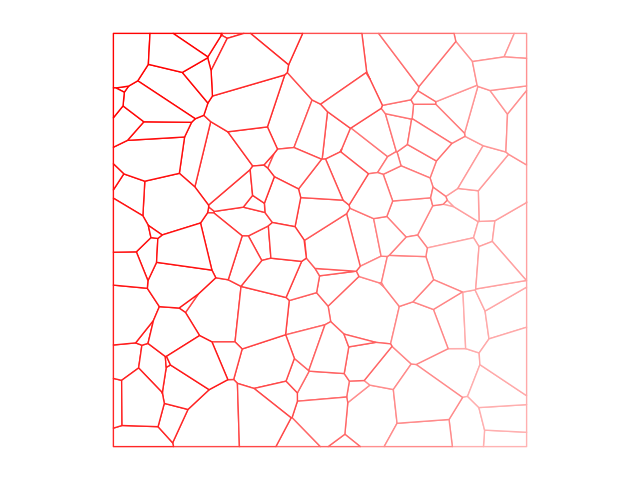

In [166]:
import matplotlib
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

# print([str(c) for c in np.linspace(0.5, 1, num=len(cross_section_tot[6]['2d']))])
coll = PolyCollection(cross_section_tot[6]['2d'], facecolors="white",  closed=True, edgecolors=[(1, 1-c, 1-c) for c in np.linspace(0.3, 1, num=len(cross_section_tot[6]['2d']))])
ax2.add_collection(coll)
ax2.axis("equal")
ax2.set_axis_off()
fig2.tight_layout()
fig2.canvas.get_width_height()
plt.savefig("temp.png")
im = Image.frombytes("RGB", fig2.canvas.get_width_height(), fig2.canvas.tostring_rgb())
im = trim(im)
crop_by = 3
im = im.crop((crop_by, crop_by, im.width-crop_by, im.height-crop_by))
im.save("temp.png")





In [139]:
np.vstack(cross_section_tot[6]['2d']).shape[0]-len(cross_section_tot[6]['2d'])

690

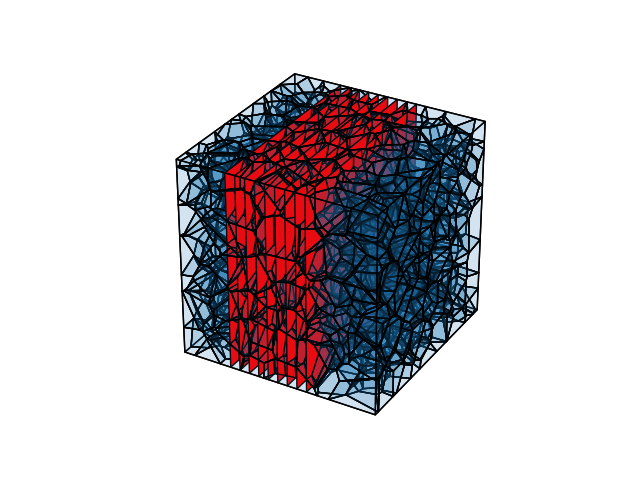

In [11]:
domain = [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]] 
fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

for cell_idx, cell in enumerate(pycells10):
    for facet_idx, facet in enumerate(cell['faces']):
        idx = np.array(facet['vertices'])
        polygon = m3.art3d.Poly3DCollection([np.array(cell['vertices'])[idx]])
        polygon.set_edgecolor('k')
        polygon.set_alpha(0.1)
        ax.add_collection3d(polygon)


for x in range(0, 9, 1):
    for cell in cross_section_tot10[x]['3d']:
        polygon = m3.art3d.Poly3DCollection([cell])
        polygon.set_color("red")
        polygon.set_edgecolor('k')
        ax.add_collection3d(polygon)
    
ax.set_xlim3d(domain[0])
ax.set_ylim3d(domain[1])
ax.set_zlim3d(domain[2])
ax.set_box_aspect((1, 1, 1))
ax.set_axis_off()
plt.show()



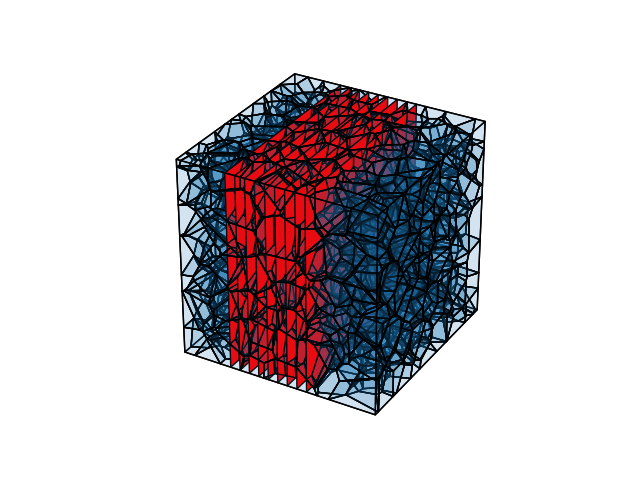

In [13]:
domain = [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]] 
fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

for cell_idx, cell in enumerate(pycells10):
    for facet_idx, facet in enumerate(cell['faces']):
        idx = np.array(facet['vertices'])
        polygon = m3.art3d.Poly3DCollection([np.array(cell['vertices'])[idx]])
        polygon.set_edgecolor('k')
        polygon.set_alpha(0.1)
        ax.add_collection3d(polygon)


for x in range(0, 9, 1):
    for cell in cross_section_tot10[x]['3d']:
        polygon = m3.art3d.Poly3DCollection([cell])
        polygon.set_color("red")
        polygon.set_edgecolor('k')
        ax.add_collection3d(polygon)
    
ax.set_xlim3d(domain[0])
ax.set_ylim3d(domain[1])
ax.set_zlim3d(domain[2])
ax.set_box_aspect((1, 1, 1))
ax.set_axis_off()
plt.show()


(-0.05, 1.05)


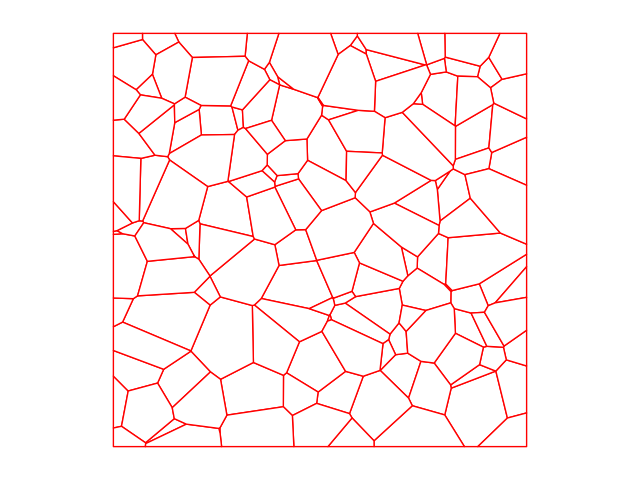

/tmp/ipykernel_875/3794413269.py:14: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  PIL.Image.frombytes("RGB", fig2.canvas.get_width_height(), fig2.canvas.tostring_rgb()).crop((115,35,505,445)).save("../figures/tot10_0_2d.png")


In [ ]:

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

coll = PolyCollection(cross_section_tot10[0]['2d'], facecolors="white", edgecolors='r')
ax2.add_collection(coll)
ax2.axis("equal")
print(ax2.get_xlim())
ax2.set_axis_off()
fig2.tight_layout()
plt.show()
PIL.Image.frombytes("RGB", fig2.canvas.get_width_height(), fig2.canvas.tostring_rgb()).crop((115,35,505,445)).save("../figures/tot10_0_2d.png")


In [23]:
cross_section_tot10[0]["2d"][0]

array([[ 0.91893525, -0.5       ],
       [ 0.90167717, -0.5       ],
       [ 0.9220282 , -0.41902691],
       [ 0.94281349, -0.43503558]])

In [19]:
dfx_tot.to_csv('dftotvor1.csv')

NameError: name 'dfx_tot' is not defined

In [34]:
#########Generazione multipla######
dfj_tot_tot=pd.DataFrame(columns=['x','y','id_sec','id_grain','g_area','id_vor'])
for k in range(1,100):
    s = np.random.default_rng().uniform(0,10,size=(100,3))
    pycells=pyvoro.compute_voronoi(
    s, [[0.0, 10.0], [0.0, 10.0], [0.0, 10.0]], 1000.0,)
    coeffs = np.array([5.0, 0.0, 0.0])
    r1=np.arange(0.2, 1, 0.1).tolist()
    cross_section_tot=[vs.compute_cross_section(coeffs = coeffs, offset = np.array([0.1+5.0, 5.0, 10.0]), points=s, domain=[[0.0, 10.0], [0.0, 10.0], [0.0, 10.0]], weights=weights)]
    for x in range(0,8):
     cross_section_tot+= [vs.compute_cross_section(coeffs = coeffs, offset = np.array([r1[x]+5.0, 5.0, 10.0]), points=s, domain=[[0.0, 10.0], [0.0, 10.0], [0.0, 10.0]], weights=weights)]
    x = [p[0] for p in cross_section_tot[0]['2d'][0]]
    y = [p[1] for p in cross_section_tot[0]['2d'][0]]
    centroid0=[(sum(x) / len(cross_section_tot[0]['2d'][0]), sum(y) / len(cross_section_tot[0]['2d'][0]))]
    for i in range(1,len(cross_section_tot[0]['2d'])):
         x = [p[0] for p in cross_section_tot[0]['2d'][i]]
         y = [p[1] for p in cross_section_tot[0]['2d'][i]]
         centroid0.append((sum(x) / len(cross_section_tot[0]['2d'][i]), sum(y) / len(cross_section_tot[0]['2d'][i])))
    id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
    grain_area=pd.DataFrame(cross_section_tot[0]['areas'],columns=['g_area'])
    df0=pd.DataFrame(centroid0,columns=['x','y'])
    df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains,grain_area], axis=1)
    for j in range(1,8):
        x = [p[0] for p in cross_section_tot[j]['2d'][0]]
        y = [p[1] for p in cross_section_tot[j]['2d'][0]]
        centroidj=[(sum(x) / len(cross_section_tot[j]['2d'][0]), sum(y) / len(cross_section_tot[j]['2d'][0]))]
        for i in range(1,len(cross_section_tot[j]['2d'])):
            x = [p[0] for p in cross_section_tot[j]['2d'][i]]
            y = [p[1] for p in cross_section_tot[j]['2d'][i]]   
            centroidj.append((sum(x) / len(cross_section_tot[j]['2d'][i]), sum(y) / len(cross_section_tot[j]['2d'][i])))
        id_sec=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot[j]['2d']),columns=['id_sec'])
        id_grains=pd.DataFrame(cross_section_tot[j]['original_indices'],columns=['id_grain'])
        grain_area=pd.DataFrame(cross_section_tot[j]['areas'],columns=['g_area'])
        dfj=pd.DataFrame(centroidj,columns=['x','y'])
        dfj=pd.concat([dfj.reset_index(drop=True), id_sec, id_grains,grain_area], axis=1)
        dfj_tot=pd.concat([df0,dfj])
        df0=dfj_tot   
    id_vor=pd.DataFrame([k]*dfj_tot.shape[0],columns=['id_vor'])
    dfj_tot=pd.concat([dfj_tot.reset_index(drop=True), id_vor], axis=1)   
    dfj_tot=pd.concat([dfj_tot ,dfj_tot_tot])
    dfj_tot_tot=dfj_tot 
    


/tmp/ipykernel_5324/1500187300.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfj_tot=pd.concat([dfj_tot ,dfj_tot_tot])


In [35]:
dfj_tot_tot

,x,y,id_sec,id_grain,g_area,id_vor
0,8.668276,-3.192797,0.1,53,5.631424,99
1,8.877768,-4.694075,0.1,48,1.366599,99
2,6.886871,-0.544753,0.1,31,0.097539,99
3,8.016879,0.419846,0.1,78,5.653518,99
4,8.425815,-1.096038,0.1,30,3.724209,99
...,...,...,...,...,...,...
282,0.702759,-0.439836,0.8,67,0.657104,1
283,0.242714,4.495346,0.8,7,0.479724,1
284,1.735436,4.637171,0.8,34,1.874793,1
285,1.324869,2.636939,0.8,43,3.353642,1
